In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('./gdrive/MyDrive/RNN_for_GCPL')

Mounted at /content/gdrive


In [1]:
import os
os.chdir('../')

In [2]:
import os
import sys
import numpy as np
from sys import getsizeof
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from itertools import product
import pickle

import math
import shutil
import torch
from torch.utils.data import Dataset
import scipy as sp
from scipy.optimize import curve_fit
import sklearn
from Code.setup import *
import datetime as dt
import time
import torch.nn as nn
import copy
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
import RNN_for_GCPL.setup

In [3]:
savepath = r'data/v4/120/main'
dataset_rs2 = GCPL_dataset_resampled3(savepath)

In [4]:
seedEverything(seed=DEFAULT_RANDOM_SEED)
input_dim = 2
output_dim = 20
num_layers = 2
bidir= True
lr = 5e-4
init_model = MyGRU(input_dim, output_dim, num_layers=num_layers,bidir = bidir)
criterion = nn.MSELoss(reduction='none')
best_model = MyGRU(input_dim, output_dim, num_layers=num_layers,bidir = bidir)
# kf = KFold(5, shuffle=True, random_state=DEFAULT_RANDOM_SEED)
gkf = GroupKFold(4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
models = []
# params = [ (30,3,False), (60, 4, True)]
params = [(20, 1, True), (20, 2, True), (30, 3, True)]
for a,b,c in params:
    model = MyGRU(input_dim, a, num_layers=b, bidir=c)
    models.append(model)
sampling = [60, 120, 180]

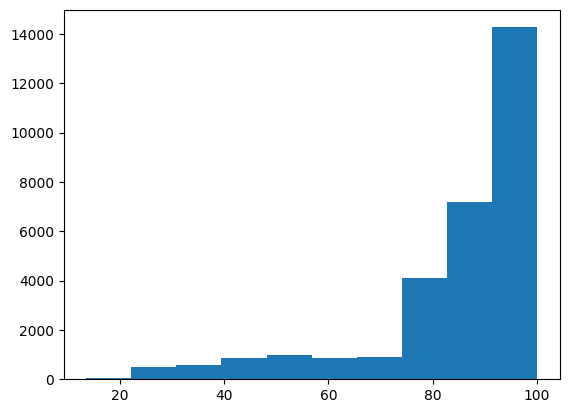

In [6]:
probs = balancing(dataset_rs2, 10)
soh, info = statistics(dataset_rs2)
clear_output()

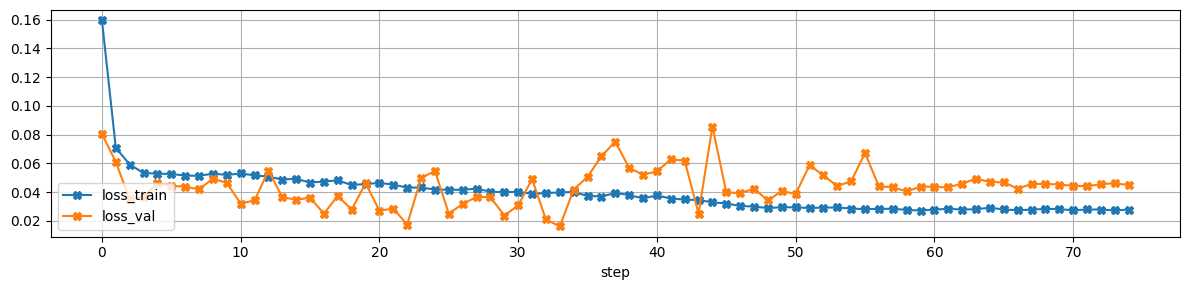

tensor(0.0450, device='cuda:0') tensor(0.1026, device='cuda:0')


In [27]:
draw_every = 25
num_epochs = 75
save_every = 10
batch_size = 256
for m in sampling:
    dataset_rs2 = GCPL_dataset_resampled3(f'data/v4/{m}/main')
    dataset_validate = GCPL_dataset_resampled3(f'data/v4/{m}/validate')
    for l, init_model in enumerate(models):
        path = f'./models/v10/{m}/{l}'
        for k, (train_indices, val_indices) in enumerate(gkf.split(dataset_rs2, groups=info.Pouch)):
            seedEverything(seed=DEFAULT_RANDOM_SEED)
            train_set = torch.utils.data.Subset(dataset_rs2, train_indices)
            val_set = torch.utils.data.Subset(dataset_rs2, val_indices)
            sampler = torch.utils.data.WeightedRandomSampler(probs[train_indices], len(train_indices)) 
            train_loader = torch.utils.data.DataLoader(train_set, batch_size, collate_fn=collate_batch, sampler=sampler)
            val_loader = torch.utils.data.DataLoader(val_set, batch_size, shuffle=True, collate_fn=collate_batch)
            model = copy.deepcopy(init_model)
            model.to(device)
            optimizer =  torch.optim.Adam(model.parameters(), lr=lr)
            sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
            handler = ModelHandler(model, 1e6, f'20 neurons, 2 layers, 120s sampling, 80% train, 20% val, k-fold No {k}.', path= path, kfold=True)
            pp = ProgressPlotter()
            counter = 0
            for i in range(num_epochs):
                model.train()
                loss_val = 0
                loss_train = 0
                for data, labels in train_loader:
                    optimizer.zero_grad()
                    preds = model(data.to(device))
                    loss = torch.sum(criterion(preds, labels.to(device)))
                    loss.backward()
                    optimizer.step()
                    loss_train += loss.detach().cpu()
                
                
                with torch.no_grad():
                    loss_train = loss_train/len(train_loader)
                    pp.add_scalar('loss_train', loss_train.detach().cpu().numpy())
                    model.eval()
                    for data, labels in val_loader:
                        preds = model(data.to(device))
                        loss = torch.sum(criterion(preds, labels.to(device)))
                        loss_val += loss.detach().cpu()
                    loss_val = loss_val/len(val_set)
                    sheduler.step(loss_val)
                    handler.check_loss(loss_val, draw_every)
                    pp.add_scalar('loss_val', loss_val.detach().cpu().numpy())
                    if loss_val > handler.best_loss:
                        counter +=1
                    else:
                        counter = 0
                    if (i+1)%draw_every == 0:
                        pp.display([['loss_train', 'loss_val']])
                    print(i, counter, loss_train*2500, loss_val*2500)
                if (i+1)%save_every==0:
                    handler.save(kfold_number=k)
                    
                    
            handler.add_pp(pp)
            handler.display()
            handler.save(kfold_number=k)
            with torch.no_grad():
                loss_val = []
                for data, labels in val_loader:
                    preds = model(data.to(device))
                    loss = criterion(preds, labels.to(device))
                    loss_val.append(loss)
                loss_val = torch.hstack(loss_val)
                print(loss_val.mean(), loss_val.std())


In [ ]:
loss = []
train_set = []
val_set = []
model = copy.deepcopy(init_model)
optimizer =  torch.optim.Adam(model.parameters(), lr=lr) 
path= f'./models/v127/2'
handler = ModelHandler(model, optimizer, train_set, train_set, 1e6, f'one batch, model No k-fold No .', path= f'./models/v2/', kfold=True)
batches = next(os.walk(path))[1]
loss_ = []
epochs_ = []
for batch in batches:
    batchpath = path+ '/' + batch
    handler.load(batchpath)
    loss_.append(handler.best_loss.cpu())
loss.append(loss_)
loss = np.array(loss)*2500
print(str(np.mean(loss))+ '±' + str(np.std(loss)))
loss



9.101615±1.1441959


array([[10.687192 ,  8.447452 , 10.22898  ,  7.7453456,  8.399106 ]],
      dtype=float32)

In [7]:
def load(path_):
    if path_.split('.')[-1] == 'pt':
        path = '/'.join(path.split('/')[:-1])
        name = path_.split('/')[-1]
        checkpoint = torch.load(path+ '/' + name, map_location=torch.device('cpu'))
        loss = [checkpoint['loss'].numpy()]
    else:
        path = path_
        files = next(os.walk(path_))[2]
        x = lambda x: int(x.split('_')[-1].split('.')[0].split('(')[0])
        files.sort(key=x)
        loss = []
        for name in files:
            checkpoint = torch.load(path+ '/' + name, map_location=torch.device('cpu'))
            loss.append(checkpoint['loss'].numpy())
    return np.array(loss)


In [40]:
path = f'./models/v127'
loss = {}
for root, dirs, files in os.walk(path):
    if dirs:
        continue
    if not files:
        continue

    loss[root] = load(root)
loss

{'./models/v10/120/2\\0': array([0.03120831, 0.02615611, 0.02615611, 0.02615611, 0.02615611,
        0.02615611, 0.02615611, 0.02615611], dtype=float32),
 './models/v10/120/2\\1': array([0.06674214, 0.06674214, 0.06674214, 0.06674214, 0.06674214,
        0.06674214, 0.06674214, 0.06674214], dtype=float32),
 './models/v10/120/2\\2': array([0.04494723, 0.03490639, 0.03198958, 0.03198958, 0.03198958,
        0.03198958, 0.03198958, 0.03198958], dtype=float32),
 './models/v10/120/2\\3': array([0.03692817, 0.019134  , 0.01421402, 0.01421402, 0.01421402,
        0.01421402, 0.01421402, 0.01421402], dtype=float32)}

In [8]:
path = f'./models/v10/120/0/0'
model = copy.deepcopy(models[0])
handler = ModelHandler(model)
handler.load(path)

In [66]:
def collate_batch_named(batch, named=True):
    sample_list = []
    label_list = []
    pouch = []
    cycle = []
    for i in batch:
        sample = np.stack([i['E'], i['I']],axis=-1)
        sample_list.append(torch.tensor(sample, dtype=torch.float32))
        label_list.append(i['SoH'])
        pouch.append(i['Pouch'])
        cycle.append(i['Cycle'])
    sequence_pad = nn.utils.rnn.pad_sequence(sample_list)
    labels = torch.tensor(label_list, dtype=torch.float32)
    if not named:
        return sequence_pad, labels    
    else:
        return sequence_pad, labels, pouch, cycle

In [71]:
dataset_validate = GCPL_dataset_resampled3(f'data/v4/120/validate')


In [75]:
batch_size=256
val_loader = torch.utils.data.DataLoader(dataset_validate, batch_size, shuffle=True, collate_fn=collate_batch_named)
with torch.no_grad():
    loss = []
    pouches = []
    soh = []
    pred = []
    cycles = []
    for data, labels, pouch, cycle in val_loader:
        preds = handler.best_model(data)
        pred.extend(preds)
        loss_ = criterion(preds, labels)
        loss.append(loss_)
        pouches.extend(pouch)
        cycles.extend(cycle)
        soh.extend(labels)
    loss = torch.hstack(loss)
    soh = torch.Tensor(soh)*50+50
    pred = torch.Tensor(pred)*50+50
    loss *= 2500 
    results = pd.DataFrame({'Pouch':pouches,'Cycle':cycles, 'Loss':loss, 'SoH':soh,'Pred':pred} )
    results.sort_values(by='Loss',axis=0, ascending=0,inplace=True)
    print(results.Loss.mean())

169.91534


In [81]:
dataset_rs2[900]

{'Pouch': 'D02',
 'Experiment': '01 GCPL Aging',
 'Filename': '120521-D2-GCPL-C2-Tnorm-500cycles_2ty_C02.mpt',
 'Qc': 46.95987706227216,
 'Qd': 46.73896043392015,
 'Qc_next': 46.83556791596987,
 'Qd_next': 46.47205726744752,
 'SoH': -0.32146539800117746,
 'SoH_next': -0.32534017467899357,
 'Cycle': 446,
 'E': array([0.66606029, 0.76768502, 0.82356281, 0.85493661, 0.88035938,
        0.90347895, 0.92494618, 0.94579888, 0.96679602, 0.98741535,
        0.99829725, 0.99752844, 0.99749325, 0.99751089, 0.99751967,
        0.99751308, 0.99747352, 0.99751528, 0.99750208, 0.99752623,
        0.99751966, 0.99752406, 0.9975087 , 0.99749103, 0.99752624,
        0.99752186, 0.99754384, 0.99751528, 0.99751526, 0.99749336,
        0.99750432, 0.99751967, 0.99749117, 0.99748222, 0.9974933 ,
        0.99752186, 0.99751747, 0.99751308, 0.99751307, 0.99335888,
        0.97773503, 0.97375047, 0.97122   , 0.96923421, 0.9676241 ,
        0.96617656, 0.96494647, 0.86124821, 0.76806556, 0.72678959,
        0.

In [73]:
results[:50]

,Pouch,Cycle,Loss,SoH,Pred
1123,G12,120,3270.493652,92.761932,35.573704
1012,G12,317,2322.932373,84.142761,35.945953
252,G12,129,2086.239746,92.489166,46.813801
843,G12,126,2023.732178,92.576981,47.591064
655,G12,122,1966.433838,92.870613,48.526123
1241,G12,130,1928.192505,92.132187,48.220993
1238,G12,133,1895.750366,92.766541,49.226330
50,G12,123,1893.242798,93.365105,49.853699
1276,G12,131,1831.805542,92.218658,49.419056
891,G12,116,1778.243530,93.367836,51.198608


,Cycle,Loss,SoH
18243,D08_1,9048.646484,100.000000
4021,G20_530,7290.429688,88.477173
4383,D13_1,6588.591797,89.766983
19734,G13_205,6474.523438,83.284973
19736,D20_1,5706.254883,88.108612
...,...,...,...
7600,G10_4,864.086670,98.863586
17602,G08_408,863.208679,47.912399
19500,G09_3,863.182983,98.723228
19060,G08_313,861.949341,49.910789


In [ ]:
loss = {}
for s in sampling:
    l_ = {}
    for i in range(3):
        path = f'./models/v10/{s}/{i}'
        batches = next(os.walk(path))[1]
        loss_ = []
        for batch in batches:
            batchpath = path+ '/' + batch
            a = load(batchpath)
            loss_.append(a)
        loss_ = torch.tensor(loss_)*2500
        l_[i] = loss_
        print(s, i, f'{loss_.mean():.3}±{loss_.std():.3}')
    loss[s] = l_

30 0 72.9±10.6
30 1 64.8±11.1
30 2 58.1±6.4
60 0 67.5±15.5
60 1 63.6±11.4
60 2 56.0±3.69
120 0 67.9±9.66
120 1 74.2±12.5
120 2 61.1±6.91
180 0 72.0±4.3
180 1 66.2±8.12
180 2 63.8±nan
300 0 77.8±6.47
300 1 78.0±3.44
300 2 72.7±7.55


In [ ]:
length = []
soh = []
info = pd.DataFrame({
            'Pouch':[],
            'SoH':[],
            "Len":[],
            })
for i in range(len(dataset_rs2)):
    one = len(dataset_rs2[i]['E'])
    soh = dataset_rs2[i]['SoH']*50+50
    if np.any(np.isnan(dataset_rs2[i]['E'])):
        print(i)
    pouch = dataset_rs2[i]['Pouch']
    if i%1000 == 0:
        print(i)
    info.loc[len(info)] = [pouch, soh, one]
info

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000


,Pouch,SoH,Len
0,D01,96.224063,250
1,D01,96.452808,248
2,D01,96.540606,257
3,D01,96.612209,255
4,D01,96.760110,248
...,...,...,...
35148,HZ,99.751757,273
35149,HZ,99.669845,273
35150,HZ,99.477225,266
35151,HZ,99.338521,273
